In [ ]:
print("tejaswee")
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random


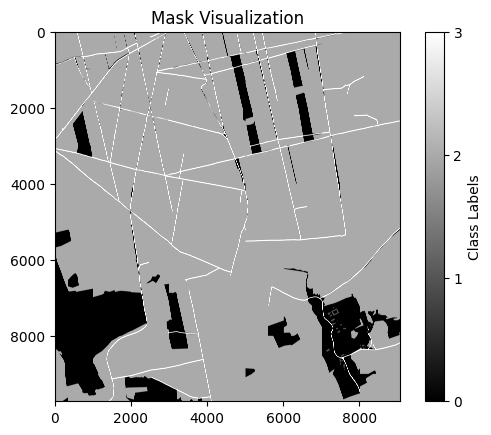

(9711, 9081, 3)
Labels are:  [0 1 2 4]  and the counts are:  [10649007    60415 75869435  1606734]


In [41]:
temp_img = cv2.imread("./landcover/images/M-33-7-A-d-2-3.tif") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...
type(temp_img)
# cmap = plt.cm.get_cmap('viridis', 4)  
temp_mask = cv2.imread("./landcover/masks/M-33-7-A-d-2-3.tif") #3 channels but all same. p
plt.imshow(temp_mask[:,:,1],cmap='gray',vmin=0,vmax=3)
plt.colorbar(ticks=[0, 1, 2, 3], label='Class Labels')
plt.title("Mask Visualization")
plt.show()
print(temp_mask.shape)
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)


In [35]:
root_directory = 'landcover/'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
img_dir=root_directory+"images/"
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    #print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite(root_directory+"256_patches/images/"+
                               image_name+"patch_"+str(i)+str(j)+".tif", single_patch_img)
                    #image_dataset.append(single_patch_img)
            

Now patchifying image: landcover/images//M-33-20-D-c-4-2.tif
Now patchifying image: landcover/images//M-33-20-D-d-3-3.tif
Now patchifying image: landcover/images//M-33-32-B-b-4-4.tif
Now patchifying image: landcover/images//M-33-48-A-c-4-4.tif
Now patchifying image: landcover/images//M-33-7-A-d-2-3.tif
Now patchifying image: landcover/images//M-33-7-A-d-3-2.tif
Now patchifying image: landcover/images//M-34-32-B-a-4-3.tif
Now patchifying image: landcover/images//M-34-32-B-b-1-3.tif
Now patchifying image: landcover/images//M-34-5-D-d-4-2.tif
Now patchifying image: landcover/images//M-34-51-C-b-2-1.tif
Now patchifying image: landcover/images//M-34-51-C-d-4-1.tif
Now patchifying image: landcover/images//M-34-55-B-b-4-1.tif
Now patchifying image: landcover/images//M-34-56-A-b-1-4.tif
Now patchifying image: landcover/images//M-34-6-A-d-2-2.tif
Now patchifying image: landcover/images//M-34-65-D-a-4-4.tif
Now patchifying image: landcover/images//M-34-65-D-c-4-2.tif
Now patchifying image: landc

In [36]:
mask_dir=root_directory+"masks/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
   
            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite(root_directory+"256_patches/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".tif", single_patch_mask)

Now patchifying mask: landcover/masks//M-33-20-D-c-4-2.tif
Now patchifying mask: landcover/masks//M-33-20-D-d-3-3.tif
Now patchifying mask: landcover/masks//M-33-32-B-b-4-4.tif
Now patchifying mask: landcover/masks//M-33-48-A-c-4-4.tif
Now patchifying mask: landcover/masks//M-33-7-A-d-2-3.tif
Now patchifying mask: landcover/masks//M-33-7-A-d-3-2.tif
Now patchifying mask: landcover/masks//M-34-32-B-a-4-3.tif
Now patchifying mask: landcover/masks//M-34-32-B-b-1-3.tif
Now patchifying mask: landcover/masks//M-34-5-D-d-4-2.tif
Now patchifying mask: landcover/masks//M-34-51-C-b-2-1.tif
Now patchifying mask: landcover/masks//M-34-51-C-d-4-1.tif
Now patchifying mask: landcover/masks//M-34-55-B-b-4-1.tif
Now patchifying mask: landcover/masks//M-34-56-A-b-1-4.tif
Now patchifying mask: landcover/masks//M-34-6-A-d-2-2.tif
Now patchifying mask: landcover/masks//M-34-65-D-a-4-4.tif
Now patchifying mask: landcover/masks//M-34-65-D-c-4-2.tif
Now patchifying mask: landcover/masks//M-34-65-D-d-4-1.tif
N

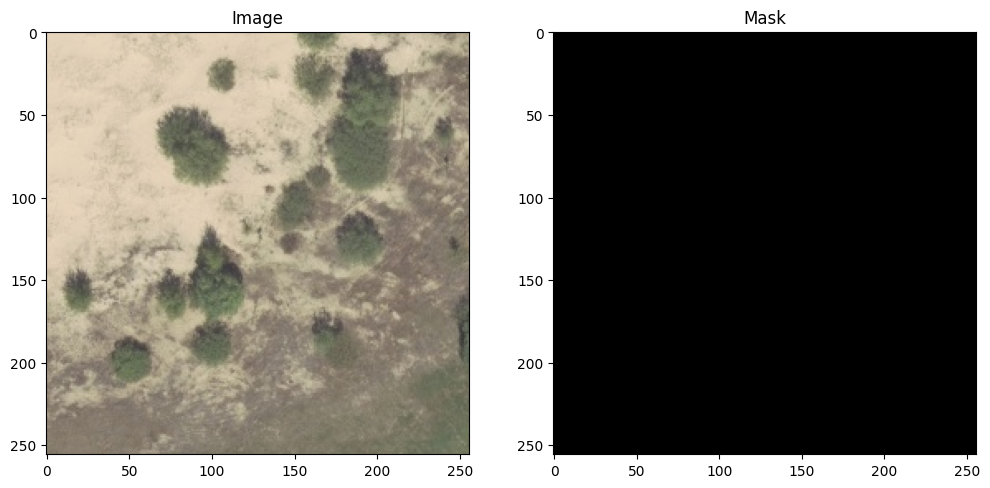

Now preparing image and masks number:  0
I am useless
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
I am useless
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
Save Me
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
I am useless
Now preparing image and masks number:  7
I am useless
Now preparing image and masks number:  8
I am useless
Now preparing image and masks number:  9
I am useless
Now preparing image and masks number:  10
I am useless
Now preparing image and masks number:  11
I am useless
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
I am useless
Now preparing image and masks number:  14
I am useless
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now prepar

Copying files: 43848 files [04:22, 167.15 files/s]


'\nYour current directory structure:\nlandcover/\n    train/\n        images/\n            img1, img2, ...\n        masks/\n            msk1, msk2, ....\n    val/\n        images/\n            img1, img2, ...\n        masks/\n            msk1, msk2, ....\n        \nCopy the folders around to the following structure... \n\n\nlandcover/\n    train_images/\n                train/\n                    img1, img2, img3, ......\n    \n    train_masks/\n                train/\n                    msk1, msk, msk3, ......\n                    \n    val_images/\n                val/\n                    img1, img2, img3, ......                \n\n    val_masks/\n                val/\n                    msk1, msk, msk3, ......\n      \n                    \n'

In [37]:
train_img_dir = "landcover/256_patches/images/"
train_mask_dir = "landcover/256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

###########################################################################

#Now, let us copy images and masks with real information to a new folder.
# real information = if mask has decent amount of labels other than 0. 

useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        print("Save Me")
        cv2.imwrite('landcover/256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('landcover/256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
        
    else:
        print("I am useless")   
        useless +=1

print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571
###############################################################
#Now split the data into training, validation and testing. 

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 

pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = 'landcover/256_patches/images_with_useful_info/'
output_folder = 'landcover/data_for_training_and_testing/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values
########################################

#Now manually move folders around to bring them to the following structure.
"""
Your current directory structure:
landcover/
    train/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....
    val/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....
        
Copy the folders around to the following structure... 


landcover/
    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                

    val_masks/
                val/
                    msk1, msk, msk3, ......
      
                    
"""

In [38]:
# https://youtu.be/0W6MKZqSke8
"""
Author: Dr. Sreenivas Bhattiprolu 

This code can be used to perform semantic segmentation of aerial / satellite 
images, especially the dataset from landcover.ai

Dataset from : https://landcover.ai/
Dataset description: https://arxiv.org/pdf/2005.02264.pdf

Link doesn't seem to work anymore: Try this one instead: https://landcover.ai.linuxpolska.com/

labels:
    0: Unlabeled background 
    1: Buildings
    2: Woodlands
    3: Water

You can use any U-net but this code demonstrates the use of pretrained encoder 
in the U-net - available as part of segmentation models library. 

To install the segmentation models library: pip install -U segmentation-models
If you are running into generic_utils error when loading segmentation models library
watch this video to fix it: https://youtu.be/syJZxDtLujs

Use the landcover_prepare_data.py to prepare your data. 
e.g., divide images to smaller patches, svae only the patches with real labels, split to train and val. 



"""

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

(256, 256)


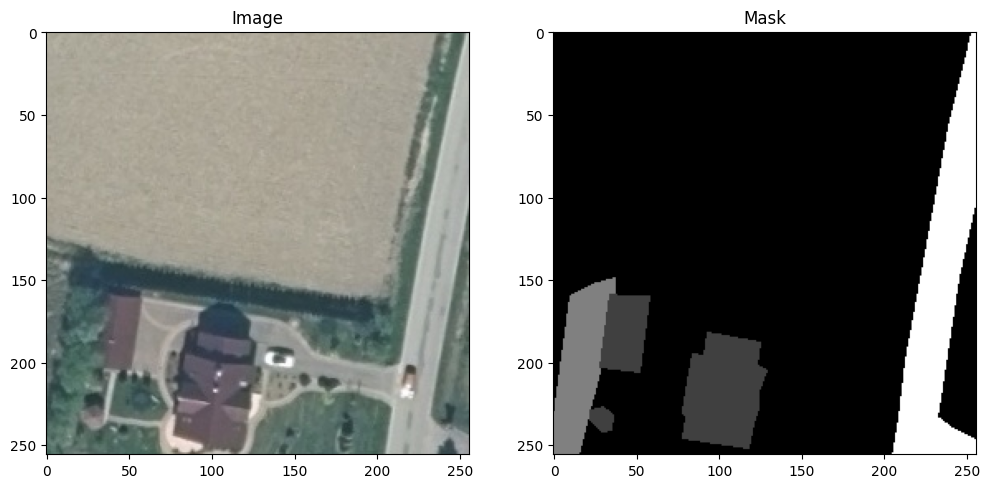

In [57]:
train_img_dir = "landcover/data_for_keras_aug/train_images/train/"
train_mask_dir = "landcover/data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num],0)
print(mask_for_plot.shape)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


Found 16443 images belonging to 1 classes.
Found 16443 images belonging to 1 classes.
iam (16, 256, 256, 1)
Labels are:  [0. 1. 2. 3. 4.]  and the counts are:  [2055   71 1248  524  198]
(16, 256, 256, 3)
image <class 'numpy.int64'>


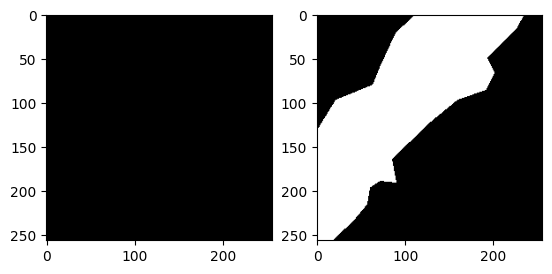

image <class 'numpy.int64'>


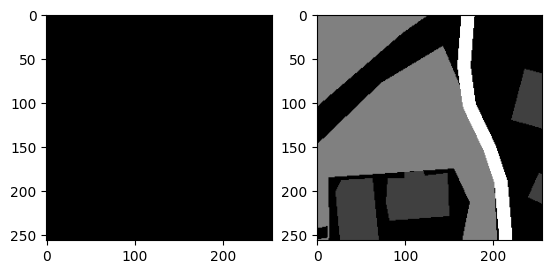

image <class 'numpy.int64'>


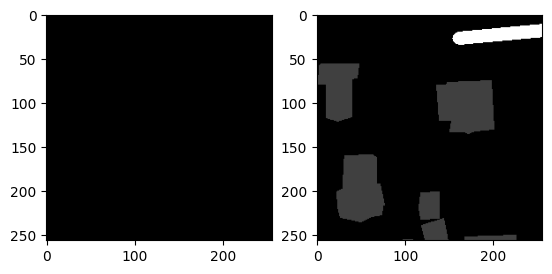

Found 5481 images belonging to 1 classes.
Found 5481 images belonging to 1 classes.
iam (16, 256, 256, 1)
Labels are:  [0. 1. 2. 3. 4.]  and the counts are:  [2259   82 1535  134   86]
(16, 256, 256, 3)
image <class 'numpy.int64'>


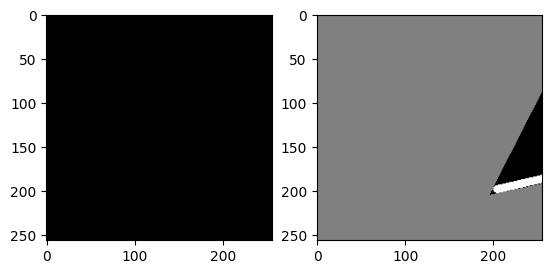

image <class 'numpy.int64'>


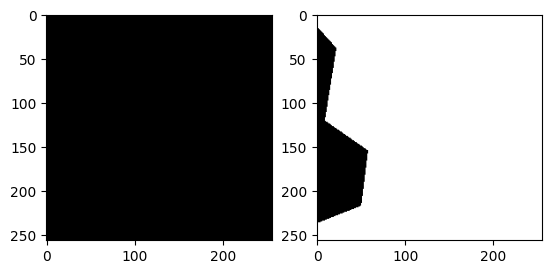

image <class 'numpy.int64'>


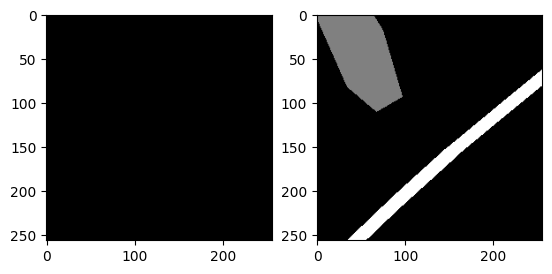

In [82]:
seed=24
batch_size= 16
n_classes=4

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    print("iam",mask.shape)
    labels, count = np.unique(mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
    print("Labels are: ", labels, " and the counts are: ", count)
    
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
    img = img.astype(np.int64)
    return (img,mask)

#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def trainGenerator(train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        
        img, mask = preprocess_data(img, mask, num_class)
        print(img.shape)
        yield (img, mask)








train_img_path = "landcover/data_for_keras_aug/train_images/"
train_mask_path = "landcover/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)

val_img_path = "landcover/data_for_keras_aug/val_images/"
val_mask_path = "landcover/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)

#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i]

    # print("image",type(image[0,0,0]))
    mask = np.argmax(y[i], axis=2)
    print("image",type(mask[0,0]))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    # print("image",type(image[0,0,0]))
    
    mask = np.argmax(y_val[i], axis=2)
    print("image",type(mask[0,0]))
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [85]:
num_train_imgs = len(os.listdir('landcover/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('landcover/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

# #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
# print(model.summary())
# print(model.input_shape)

In [86]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

iam (16, 256, 256, 1)
Labels are:  [0. 1. 2. 3. 4.]  and the counts are:  [2251   52 1619  106   68]
(16, 256, 256, 3)
iam (16, 256, 256, 1)
Labels are:  [0. 2. 3. 4.]  and the counts are:  [1604 1477  979   36]
(16, 256, 256, 3)
Epoch 1/25


TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.